# 4. Integrating ODEs using `odeint`

First, import some stuff we'll need. We give some of them nicknames to save typing later

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

The function `odeint`, which is found in the `integrate` submodule of the `scipy` package, integrates ordinary differential equations of the form
$$
\newcommand{\yy}{\mathbf{y}}
\newcommand{\ff}{\mathbf{f}}
\frac{\mathrm{d} \yy}{\mathrm{d}t} = \ff(\yy, t),
$$where $\yy$ is a vector in $\mathbb{R}^n$, or
$$
\dot{\yy} =  \ff(\yy, t).
$$
That is, it provides a numerical solution of the *initial value problem* given by this differential equation, together with an initial condition
$$
\yy(t = t_0) = \yy_0,
$$
returning the solution curve (or trajectory) $\yy(t)$ as a function of time $t$, within a certain (finite!) range of values of $t$.

Writing $\yy = (y_1, \ldots, y_n)$, we have a system of the form
\begin{align}
\dot{y_1} &= f_1(y_1, \ldots, y_n, t) \\
\dot{y_2} &= f_2(y_1, \ldots, y_n, t) \\
&\ldots \\
\dot{y_n} &= f_n(y_1, \ldots, y_n, t)
\end{align}

Note that in fact, *any* ordinary (system of) ordinary differential equation(s) can be written in this form by defining new variables to represent higher-order derivatives, and incorporating them into the vector $\yy$ of variables.

To use `odeint`, we must define at least the Python function `f` which implements the mathematical function $\ff$. It must take a vector `y` and a time `t`,
and return the new vector `f(y,t)`.

## 1D equations

The simplest case is when the spatial dimension is $n=1$. For example, we could wish to solve the ODE
$
\dot{y} = ay,
$
whose exact solution is, of course, $y(t) = y_0 \exp(a t)$.

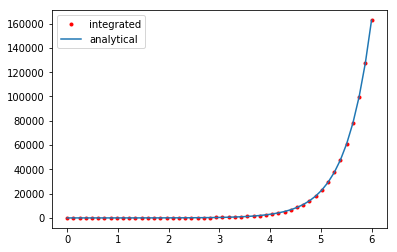

In [2]:
a = 2.0
def f(y, t):
    return a*y
times = np.linspace(0,6)
y0 = 1.0
y_output = odeint(f, y0, times)
y_exact = y0*np.exp(a*times)
plt.plot(times, y_output, 'r.', label='integrated')
plt.plot(times, y_exact, label='analytical')
plt.legend()
plt.show()

## n-D equations
$
\newcommand{\yy}{\mathbf{y}}
\newcommand{\ff}{\mathbf{f}}
$
Now we see how to do it for a set of four simultaneous equations.
The function $f$ still takes a single variable $\yy$, and returns a single thing $d\yy/dt$, but this variable $\yy$ is a vector containing 4 things (i.e. an array with size 4x1).
Although you can manipulate this numpy array however you wish, it is often clearest (and clear code is a good thing) to unpack it into separate names in the beginning of your $f$ function, and pack up the results at the end.
In this toy example the names are `y1` through `y4` but you should use names that describe the physical parameters in your problem.

In [3]:
def fvector(yvector, t):
    """
    A function that returns the time derivative of `yvector`,
    where `yvector` is a vector with 4 elements.
    """
    # unpack the vector into 4 variables
    y1, y2, y3, y4 = yvector
    # specify the four differential equations
    # (these are made up)
    dy1_dt = 1.6 * y1
    dy2_dt = 1.5 * y2
    dy3_dt = -1 * y3
    dy4_dt = -y2 + y3
    # pack up the four results into a single array to return
    dyvector_dt = np.array([dy1_dt, dy2_dt, dy3_dt, dy4_dt])
    return dyvector_dt

# As before, specify the times we wish solutions at
times = np.linspace(0,6)
# Now our initial condition is also a vector
yvector0 = np.array([0.5, 2.0, 1e4, 2e3])
# Then solve using odeint
yvector_output = odeint(fvector, yvector0, times)

You will see here that the output is an array containing 50 timesteps x 4 variables.

In [4]:
yvector_output.shape

(50, 4)

If we translate the array, using the `.T` attribute, we'll get it to be 4 variables x 50 timesteps

In [5]:
yvector_output.T.shape

(4, 50)

That is more convenient for slicing back up into four arrays, one for each variable, each being 50 elements long:

In [6]:
y1, y2, y3, y4 = yvector_output.T

We can now plot them all

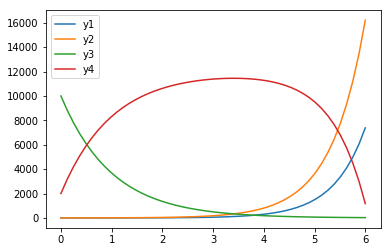

In [7]:
plt.plot(times, y1, label='y1')
plt.plot(times, y2, label='y2')
plt.plot(times, y3, label='y3')
plt.plot(times, y4, label='y4')
plt.legend()
plt.show()

# Calculating X in a reactor with pressure drop

To see where these equations come from, see page 183-188 in the textbook "Essentials of Chemical Reaction Engineering" by Fogler. It is modeling a gas flowing through a packed bed reactor. But all you need to know is that $X$ is the conversion (of species A into other things due to the chemical reaction) and $y$ is the ratio of the pressure, to the pressure at the inlet, i.e. it starts at 1 and decreases, because of the catalyst getting in the way of the gas.

This time we have two variables to integrate (conversion $X$ and pressure ratio $y$), so our function must accept and return a vector. We integrate over weight of catalyst $W$, not time $t$.
The differential equations are:

$$\frac{\mathrm{d} X}{\mathrm{d} W} = \frac{-r_A'}{F_{A0}}$$
$$\frac{\mathrm{d} y}{\mathrm{d} W} = -\alpha \frac{(1+\epsilon X)}{2y}$$


In [8]:
def dYvecdW(Yvec,W):
    """
    Return dY/dW, where Y is a vector containing the values X and y
    """
    X, y = Yvec # unpack values from Y vector into two variables
    # Explicit equations
    epsilon = -0.15
    kprime = 0.0074
    Fa0 = 0.1362
    alpha = 0.0367
    raprime = -1*kprime*(1-X)/(1+epsilon*X) * y
    f = (1+epsilon*X)/y # ratio of v / v0
    # Differential equations
    dXdW = -raprime / Fa0
    dydW = -1*alpha * (1 + epsilon * X)/ (2*y) 
    return [dXdW, dydW]  # pack up three differential equations into the dYvecdV vector

Set up the steps you want to integrate over. In this case it's Weight not Time

In [9]:
W_output = np.linspace(0, 27., num=50) # Range for the weight of catalyst of the reactor

Set up the initial conditions, as a vector of the two values

In [10]:
Y0 = [0., 1.] # Initial values for the dependent variables i.e X and y

Perform the integration, and extract the results

In [11]:
Y_result = odeint(dYvecdW, Y0, W_output) # perform the integration
X, y = Y_result.T # extract columns by transposing matrix and splitting into two variables

Now we can plot the results

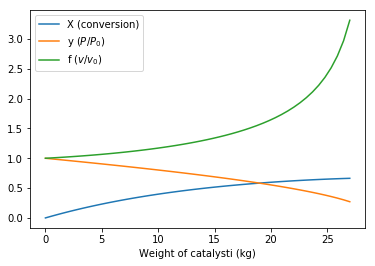

In [12]:
epsilon = -0.15
f = (1+epsilon*X)/y # volumetric flow rate ratio

plt.plot(W_output, X, label='X (conversion)')
plt.plot(W_output, y, label='y ($P/P_0$)')
plt.plot(W_output, f, label='f ($v/v_0$)')
plt.legend(loc='upper left')
plt.xlabel('Weight of catalysti (kg)')

plt.show()

# Integrating other variables
Sometimes it's convenient to integrate things like $N_{tot}$ or Volume as well as the variables that you think you care most about. Just add them to your vector.